In [1]:
from funlib.geometry import Coordinate
from dacapo.experiments.architectures import CNNectomeUNetConfig
from dacapo.experiments.tasks.distance_task_config import DistanceTaskConfig

import torch

input_voxel_size = (16, 16, 16)
output_voxel_size = (8, 8, 8)

channels = [
    "ecs",  # extra cellular space
    "plasma_membrane",
    "mito",
    "mito_membrane",
    "vesicle",
    "vesicle_membrane",
    "mvb",  # endosomes
    "mvb_membrane",
    "er",
    "er_membrane",
    "eres",
    "nucleus",
    "microtubules",
    "microtubules_out",
]

architecture_config = CNNectomeUNetConfig(
    name="CellMapArchitecture",
    input_shape=Coordinate(
        216, 216, 216
    ),  # can be changed
    eval_shape_increase=Coordinate(
        72, 72, 72
    ),  # can be changed
    fmaps_in=1,
    num_fmaps=12,
    fmaps_out=72,
    fmap_inc_factor=6,
    downsample_factors=[(2, 2, 2), (3, 3, 3), (3, 3, 3)],
    constant_upsample=True,
    upsample_factors=[(2, 2, 2)],
)

task_config = DistanceTaskConfig(
    name="DistancePrediction",
    # important
    channels=channels,
    scale_factor=50,  # target = tanh(distance / scale)
    # training
    mask_distances=True,
    # evaluation
    clip_distance=50,
    tol_distance=10,
)

# create backbone from config
architecture = architecture_config.architecture_type(architecture_config)

# initialize task from config
task = task_config.task_type(task_config)

# adding final layers/activations to create the model
model = task.create_model(architecture)


path_to_weights = "/nrs/cellmap/pattonw/crop_num_experiment/scratch_distances_many_all_many_8nm_upsample-unet_default__2/checkpoints/mito__f1_score"
weights = torch.load(path_to_weights, map_location="cuda")
model.load_state_dict(weights["model"])
model.to("cuda")
model.eval()

import numpy as np
x = torch.rand((1, 1, 216,216,216)).to("cuda")
with torch.no_grad():
    outputs = model(x)
# set model to input mode

# Export the model
# torch.onnx.export(model,                     # model being run
#                   x.to("cuda"),                         # model input (or a tuple for multiple inputs)
#                   "cellmap_model.onnx",      # where to save the model (can be a file or file-like object)
#                   export_params=True,        # store the trained parameter weights inside the model file
#                   opset_version=11,          # the ONNX version to export the model to
#                   do_constant_folding=True,  # whether to execute constant folding for optimization
#                   input_names = ['input'],   # the model's input names
#                   output_names = ['output'], # the model's output names
#                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
#                                 'output' : {0 : 'batch_size'}},
# #verbose=True,
# )


/groups/scicompsoft/home/ackermand/miniconda3/envs/neuroglancer_interactive_inference/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/groups/scicompsoft/home/ackermand/miniconda3/envs/neuroglancer_interactive_inference/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
import onnx

# Load the ONNX model
model = onnx.load("cellmap_model.onnx")

# Check it is well-formed
onnx.checker.check_model(model)

print(onnx.helper.printable_graph(model.graph))



graph torch-jit-export (
  %input[FLOAT, batch_sizex1x216x216x216]
) initializers (
  %architecture.unet.0.l_conv.0.conv_pass.0.weight[FLOAT, 12x1x3x3x3]
  %architecture.unet.0.l_conv.0.conv_pass.0.bias[FLOAT, 12]
  %architecture.unet.0.l_conv.0.conv_pass.2.weight[FLOAT, 12x12x3x3x3]
  %architecture.unet.0.l_conv.0.conv_pass.2.bias[FLOAT, 12]
  %architecture.unet.0.l_conv.1.conv_pass.0.weight[FLOAT, 72x12x3x3x3]
  %architecture.unet.0.l_conv.1.conv_pass.0.bias[FLOAT, 72]
  %architecture.unet.0.l_conv.1.conv_pass.2.weight[FLOAT, 72x72x3x3x3]
  %architecture.unet.0.l_conv.1.conv_pass.2.bias[FLOAT, 72]
  %architecture.unet.0.l_conv.2.conv_pass.0.weight[FLOAT, 432x72x3x3x3]
  %architecture.unet.0.l_conv.2.conv_pass.0.bias[FLOAT, 432]
  %architecture.unet.0.l_conv.2.conv_pass.2.weight[FLOAT, 432x432x3x3x3]
  %architecture.unet.0.l_conv.2.conv_pass.2.bias[FLOAT, 432]
  %architecture.unet.0.l_conv.3.conv_pass.0.weight[FLOAT, 2592x432x3x3x3]
  %architecture.unet.0.l_conv.3.conv_pass.0.bias[FLO

In [2]:
import onnxruntime as ort
import numpy as np
import torch
import zarr
import time

zarr_root = zarr.open(f"/groups/cellmap/cellmap/data/jrc_mus-liver/jrc_mus-liver.n5", mode="r",)
print(zarr_root['volumes/raw/s1'].shape)
raw_16nm_data = np.reshape(zarr_root['volumes/raw/s1'][4000:4000+216, 5800:5800+216, 1800:1800+216]/255.0, (1,1,216,216,216))
batch_size = 4
raw_16nm_data = np.concatenate([raw_16nm_data for i in range(batch_size)], axis = 0)
print(raw_16nm_data.shape)
t=time.time()
with torch.no_grad():
    outputs = model(torch.from_numpy(raw_16nm_data).float().to("cuda"))
print(outputs.shape, time.time()-t)
outputs = outputs.cpu()
#ort_session = ort.InferenceSession("cellmap_model.onnx", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

# t = time.time()
# outputs = ort_session.run(
#     None,
#     {"input":  raw_16nm_data.astype(np.float32)},
# )
# print(outputs[0].shape,(time.time() - t)/batch_size)


(4466, 6364, 6373)
(4, 1, 216, 216, 216)
torch.Size([4, 14, 68, 68, 68]) 0.04871988296508789


<class 'torch.Tensor'>
tensor(0.2489)


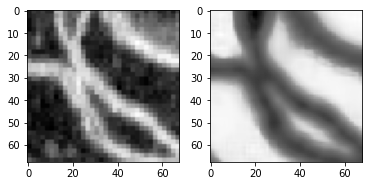

: 

In [12]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
print(type(outputs[0][0][1]))
fig, axs = plt.subplots(1, 2)
raw_16nm_data_upsample = raw_16nm_data[0][0]
raw_16nm_data_upsample = raw_16nm_data_upsample.repeat(2, axis=0).repeat(2, axis=1).repeat(2, axis=2)

output = np.zeros((432,432,432))
output[216-34:216+34, 216-34:216+34, 216-34:216+34] = outputs[0][8]
#axs[0].imshow(raw_16nm_data_upsample[:,:,216])
#axs[1].imshow(output[:,:,216])
axs[0].imshow(raw_16nm_data_upsample[216-34:216+34, 216-34:216+34, 216],cmap='Greys')
axs[1].imshow(outputs[0][8][:,:,34],cmap='Greys')
print(outputs[0][8][25,25,34])

In [10]:
# attempt batches
import torch
torch.randint(255, (1, 10),dtype = torch.uint8)

tensor([[240, 242, 215,   1, 182,  63, 239, 167, 159, 141]], dtype=torch.uint8)

In [5]:
import onnxruntime as ort
print( ort.get_device()  )


GPU
